<a href="https://colab.research.google.com/github/clyde2020/ML_Portfolio/blob/main/Satellite_Image_Interpretation/Satellite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
import random
!pip install keras-tuner -q
from keras_tuner import RandomSearch
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model, Model, Sequential
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from keras.callbacks import ReduceLROnPlateau
import cv2

from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from tqdm import tqdm
import keras
from keras.layers import (BatchNormalization, Dense, GlobalAveragePooling2D, 
                          Lambda, Dropout, InputLayer, Input, GlobalMaxPooling2D
)

from google.colab import drive
drive.mount('/content/gdrive')

     |████████████████████████████████| 98 kB 3.6 MB/s 
Mounted at /content/gdrive


# Initialize variables

In [2]:
host_folder = '/content/gdrive/MyDrive/Satellite'  # Mandatory update
source_folder = '{}/data'.format(host_folder)
train_folder = '{}/Train'.format(host_folder)
valid_folder = '{}/Valid'.format(host_folder)

labels = os.listdir(source_folder)
batch_size = 16
num_class = len(labels)

# View data

In [3]:
def get_image(path):
  im_bgr = cv2.imread(path)
  im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
  return im_rgb

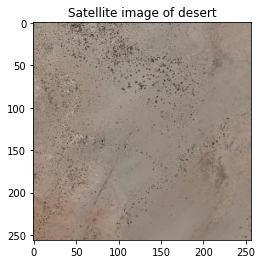

(256, 256, 3)


In [25]:
path = '/content/gdrive/MyDrive/Satellite/data/desert/desert(58).jpg'  # Mandatory update
for cat in labels:
  if cat in path:
    name = cat
new_image = get_image(path=path)
plt.title(f'Satellite image of {name}')
plt.imshow(new_image)
plt.show()

print(new_image.shape)
image_size = new_image.shape

In [6]:
samples = []
for i in range(num_class):
  source = '{}/{}'.format(source_folder, labels[i])
  source_list_len = len(os.listdir(source))
  samples.append(source_list_len)

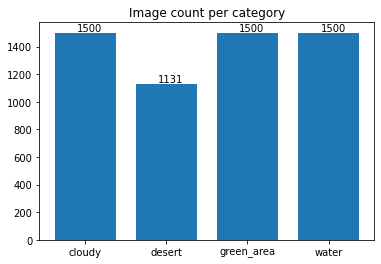

In [7]:
fig, ax = plt.subplots()
width = .75
ax.bar(labels, samples, width)
plt.title('Image count per category')

for i in range(num_class):
  plt.annotate(samples[i], (i - 0.1, samples[i] + 10))

plt.show()

# Process data for Image dataframe

In [8]:
sample = np.min(samples)
split = int(0.1 * sample)

In [9]:
os.mkdir(train_folder)
os.mkdir(valid_folder)

for num in range(len(labels)):
  os.mkdir('{}/{}'.format(train_folder, labels[num]))
  os.mkdir('{}/{}'.format(valid_folder, labels[num]))

In [10]:
def copy_data(cat, label):
  source = '{}/{}'.format(source_folder, cat)
  source_list = os.listdir(source)
  df_tmp = pd.DataFrame({'id': source_list, 'label': label})
  df_tmp_1 = df_tmp.sample(sample)
  df_tmp_1 = shuffle(df_tmp_1)
  v_list = list(df_tmp_1['id'][:split])
  t_list = list(df_tmp_1['id'][split:])
  
  dest_train = '{}/{}'.format(train_folder, cat)
  dest_valid = '{}/{}'.format(valid_folder, cat)

  for fname in t_list:
    origin = os.path.join(source, fname)
    shutil.copy(src=origin, dst=dest_train)
  for fname in v_list:
    origin = os.path.join(source, fname)
    shutil.copy(src=origin, dst=dest_valid)
  
  return df_tmp_1

In [11]:
df_c = copy_data(labels[0], 0)
df_d = copy_data(labels[1], 1)
df_g = copy_data(labels[2], 2)
df_w = copy_data(labels[3], 3)

In [12]:
# Put into single dataframe
df = pd.concat([df_c, df_d, df_g, df_w], axis=0).reset_index(drop=True)

# Transfer learning

## Process data for Transfer learning

In [13]:
def get_data(source):
  # Initialize variables
  folders = os.listdir(source)
  image_list = []

  # Add image names to list
  for folder in folders:
    files_list = os.listdir('{}/{}'.format(source, folder))
    for file in files_list: 
      image_list.append(file)

  # Set up one-hot vector labels
  df_images = df[df['id'].isin(image_list)]
  y = list(df_images['label'])
  y = to_categorical(y)

  # Initialize variables
  data_size = len(y)
  X = np.zeros([data_size, image_size[0], image_size[1], image_size[2]])
  i = 0

  # Set up image array
  for folder in folders:
    files_list = os.listdir('{}/{}'.format(source, folder))
    for file in files_list: 
      path = '{}/{}/{}'.format(source, folder, file)
      image = load_img(path, 
                      target_size=image_size)
      image = img_to_array(image)
      image = image * (1. / 255)
      X[i] = image
      i += 1

  return X, y

In [14]:
X_train, y_train = get_data(source=train_folder)
X_valid, y_valid = get_data(source=valid_folder)

## Get Feature maps from Pretrained models

In [15]:
def get_features(model_name, data_preprocessor, input_size, data):
  input_layer = Input(input_size)
  preprocessor = Lambda(data_preprocessor)(input_layer)
  base_model = model_name(weights='imagenet',
                          include_top=False,
                          input_shape=input_size)(preprocessor)
  avg = GlobalAveragePooling2D()(base_model)
  feature_extractor = Model(inputs=input_layer,
                            outputs=avg)
  
  feature_maps = feature_extractor.predict(data, 
                                           batch_size=batch_size, 
                                           verbose=1)
  print('Feature maps shape: ', feature_maps.shape)
  return feature_maps

In [16]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  image_size,
                                  X_train)

from keras.applications.xception import Xception, preprocess_input

xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 image_size,
                                 X_train)

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

resnet50_preprocessor = preprocess_input
resnet50_features = get_features(ResNet50,
                                 resnet50_preprocessor,
                                 image_size,
                                 X_train)

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   image_size,
                                   X_train)

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

vgg_preprocessor = preprocess_input
vgg_features = get_features(VGG16,
                            vgg_preprocessor,
                            image_size,
                            X_train)

255/255 [==============================] - 15s 21ms/step
Feature maps shape:  (4072, 2048)
255/255 [==============================] - 8s 28ms/step
Feature maps shape:  (4072, 2048)
255/255 [==============================] - 7s 22ms/step
Feature maps shape:  (4072, 2048)
255/255 [==============================] - 16s 50ms/step
Feature maps shape:  (4072, 1536)
255/255 [==============================] - 8s 26ms/step
Feature maps shape:  (4072, 512)


In [17]:
final_features_train = np.concatenate([inception_features,
                                 xception_features,
                                 inc_resnet_features,
                                 resnet50_features,
                                 vgg_features],
                                axis=-1)
print('Final feature maps shape ', final_features_train.shape)

Final feature maps shape  (4072, 8192)


In [18]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  image_size,
                                  X_valid)

from keras.applications.xception import Xception, preprocess_input

xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 image_size,
                                 X_valid)

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

resnet50_preprocessor = preprocess_input
resnet50_features = get_features(ResNet50,
                                 resnet50_preprocessor,
                                 image_size,
                                 X_valid)

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   image_size,
                                   X_valid)

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

vgg_preprocessor = preprocess_input
vgg_features = get_features(VGG16,
                            vgg_preprocessor,
                            image_size,
                            X_valid)

29/29 [==============================] - 2s 31ms/step
Feature maps shape:  (452, 2048)
29/29 [==============================] - 2s 33ms/step
Feature maps shape:  (452, 2048)
29/29 [==============================] - 2s 26ms/step
Feature maps shape:  (452, 2048)
29/29 [==============================] - 5s 56ms/step
Feature maps shape:  (452, 1536)
29/29 [==============================] - 1s 38ms/step
Feature maps shape:  (452, 512)


In [19]:
final_features_valid = np.concatenate([inception_features,
                                 xception_features,
                                 inc_resnet_features,
                                 resnet50_features,
                                 vgg_features],
                                axis=-1)
print('Final feature maps shape ', final_features_valid.shape)

Final feature maps shape  (452, 8192)


## Define and execute Transfer learning model

In [20]:
dnn = Sequential([InputLayer(final_features_train.shape[1:]),
                  Dropout(0.7),
                  Dense(num_class, activation='softmax')
                  ])

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-2)

dnn.compile(optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='accuracy',
                              factor=0.8,
                              patience=3,
                              cooldown=2,
                              min_lr=1e-4
                              )

mc = ModelCheckpoint(monitor='val_accuracy', 
                    #  filepath='/content/gdrive/MyDrive/Satellite/Saved_data/Xfer_bestmodel_011722.h5', 
                     filepath='/content/gdrive/MyDrive/Satellite/Saved_data/', 
                     verbose=1, 
                     save_best_only=True, 
                     mode='max'
                     )

cb = [reduce_lr, mc]

In [21]:
history = dnn.fit(final_features_train,
                  y_train,
                  batch_size=batch_size,
                  epochs=100,
                  validation_data=(final_features_valid, y_valid),
                  callbacks=cb
                  )

Epoch 1/100
255/255 [==============================] - ETA: 0s - loss: 6.1148 - accuracy: 0.3048
Epoch 00001: val_accuracy improved from -inf to 0.58850, saving model to /content/gdrive/MyDrive/Satellite/Saved_data/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Satellite/Saved_data/assets
255/255 [==============================] - 2s 7ms/step - loss: 6.1148 - accuracy: 0.3048 - val_loss: 1.3082 - val_accuracy: 0.5885 - lr: 0.0300
Epoch 2/100
244/255 [===========================>..] - ETA: 0s - loss: 6.0053 - accuracy: 0.3758
Epoch 00002: val_accuracy did not improve from 0.58850
255/255 [==============================] - 1s 3ms/step - loss: 5.9495 - accuracy: 0.3782 - val_loss: 3.2725 - val_accuracy: 0.3341 - lr: 0.0300
Epoch 3/100
250/255 [============================>.] - ETA: 0s - loss: 5.6406 - accuracy: 0.4210
Epoch 00003: val_accuracy did not improve from 0.58850
255/255 [==============================] - 1s 3ms/step - loss: 5.6449 - accuracy: 0.4222 - val_loss: 1.81

# 6 CNN layer model

## Process data for model

In [22]:
df = pd.concat([df, pd.get_dummies(df['label'])], axis=1)
df.drop(['label'], axis=1, inplace=True)

In [30]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1/255.0,
                                  rotation_range=45,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1/255.0)  

validation_generator = validation_datagen.flow_from_directory(
    valid_folder,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical') 

Found 4072 images belonging to 4 classes.
Found 452 images belonging to 4 classes.


## Define and execute model

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, 
                            kernel_size=3, 
                            input_shape=image_size, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=32, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=64, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=64, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=96, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=96, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=192, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=7e-3)

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['acc']
              )

reduce_lr = ReduceLROnPlateau(monitor='acc',
                              factor=0.6,
                              patience=1,
                              cooldown=2,
                              min_lr=1e-4
                              )
es = EarlyStopping(monitor='acc', 
                   min_delta=0.003, 
                   patience=7,
                   verbose=1, 
                   mode='auto'
                   )
mc = ModelCheckpoint(monitor='val_acc', 
                     filepath='/content/gdrive/MyDrive/Satellite/Saved_data/6L2_bestmodel_011722.h5', 
                     verbose=1, 
                     save_best_only=True, 
                     mode='max'
                     )

cd = [reduce_lr, mc]

In [32]:
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=cd
                    )

Epoch 1/20
128/128 [==============================] - ETA: 0s - loss: 0.6996 - acc: 0.7159
Epoch 00001: val_acc improved from -inf to 0.26991, saving model to /content/gdrive/MyDrive/Satellite/Saved_data/6L2_bestmodel_011722.h5
128/128 [==============================] - 64s 476ms/step - loss: 0.6996 - acc: 0.7159 - val_loss: 1.7785 - val_acc: 0.2699 - lr: 0.0070
Epoch 2/20
128/128 [==============================] - ETA: 0s - loss: 0.5934 - acc: 0.7058
Epoch 00002: val_acc improved from 0.26991 to 0.36504, saving model to /content/gdrive/MyDrive/Satellite/Saved_data/6L2_bestmodel_011722.h5
128/128 [==============================] - 60s 466ms/step - loss: 0.5934 - acc: 0.7058 - val_loss: 1.7952 - val_acc: 0.3650 - lr: 0.0070
Epoch 3/20
128/128 [==============================] - ETA: 0s - loss: 0.5240 - acc: 0.7588
Epoch 00003: val_acc did not improve from 0.36504
128/128 [==============================] - 58s 450ms/step - loss: 0.5240 - acc: 0.7588 - val_loss: 1.2409 - val_acc: 0.2367 - 

# Evaluate the validation predictions a bit further

In [ ]:
model = load_model('/content/gdrive/MyDrive/Satellite/Saved_data/6L2_bestmodel_010822.h5')

In [ ]:
model.evaluate(validation_generator)

14/14 [==============================] - 1s 79ms/step - loss: 0.2136 - acc: 0.9273


[0.21361884474754333, 0.9272727370262146]

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1/255.0)  

val_test_generator = validation_datagen.flow_from_directory(
    valid_folder,
    target_size=(256, 256),
    batch_size=1,
    class_mode='sparse',
    shuffle=False) 

Found 440 images belonging to 4 classes.


In [ ]:
len_val_test = len(val_test_generator)

val_test_pred = model.predict(val_test_generator, 
                         steps=len_val_test,
                         verbose=1)#[:, 0]

440/440 [==============================] - 2s 4ms/step


In [ ]:
df_vt_true = pd.DataFrame({'label': val_test_generator.classes})

In [ ]:
# Dataframe one hot no id
df_labels = pd.get_dummies(df_vt_true['label'])
val_test_true = df_labels.to_numpy()
val_test_pred = np.round(val_test_pred)
val_test_pred.astype(int)

In [ ]:
truths = []
preds = []
final = []
list_length = len(val_test_true)

for num in range(list_length):
  truths.append(np.argmax(val_test_true[num]))

for num in range(list_length):
  preds.append(np.argmax(val_test_pred[num]))

for num in range(list_length):
  final.append(preds[num] == truths[num])

In [ ]:
acc_val_test = final.count(True) / (final.count(True) + final.count(False))
print('Validation accuracy: {:.3f}'.format(acc_val_test))

Validation accuracy: 0.927
